Load the data, check for nulls

In [26]:
import pandas as pd

train_df = pd.read_csv('exoTrain.csv')
test_df = pd.read_csv('exoTest.csv')

df = pd.concat([train_df, test_df], axis=0)
df.head

<bound method NDFrame.head of      LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6   FLUX.7   
0        2    93.85    83.81    20.10   -26.98   -39.56  -124.71  -135.18  \
1        2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81   -86.55   
2        2   532.64   535.92   513.73   496.92   456.45   466.00   464.50   
3        2   326.52   347.39   302.35   298.13   317.74   312.70   322.33   
4        2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48  -998.34   
..     ...      ...      ...      ...      ...      ...      ...      ...   
565      1   374.46   326.06   319.87   338.23   251.54   209.84   186.35   
566      1    -0.36     4.96     6.25     4.20     8.26    -9.53   -10.10   
567      1   -54.01   -44.13   -41.23   -42.82   -39.47   -24.88   -31.14   
568      1    91.36    85.60    48.81    48.69    70.05    22.30    11.63   
569      1  3071.19  2782.53  2608.69  2325.47  2089.37  1769.56  1421.09   

      FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.31

Check for nulls, clean data

In [27]:
df.dtypes

LABEL          int64
FLUX.1       float64
FLUX.2       float64
FLUX.3       float64
FLUX.4       float64
              ...   
FLUX.3193    float64
FLUX.3194    float64
FLUX.3195    float64
FLUX.3196    float64
FLUX.3197    float64
Length: 3198, dtype: object

In [28]:
print(df.isnull().sum())

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64


Great, no nulls. Visualizations? Yes.

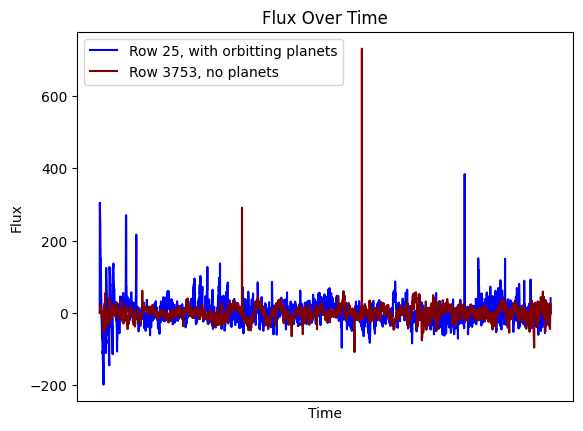

In [29]:
import matplotlib.pyplot as plt

d = df
def twoRRows():
    # r = d.sample(2)
# Just to ensure I can see one star with an exoplanet & one without
    r2 = d[d['LABEL'] == 2].sample(1)
    r1 = d[d['LABEL'] == 1].sample(1)
    r = pd.concat([r2, r1])

    for index, row in r.iterrows():
        # plt.plot(row.index, row.values, label=f'Row {index}')
        if row['LABEL'] == 1:
            plt.plot(row.index, row.values, label=f'Row {index}, no planets', color='maroon')
        else:
            plt.plot(row.index, row.values, label=f'Row {index}, with orbitting planets', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('Flux Over Time')
    plt.xticks([])
    plt.legend()
    plt.show()
twoRRows()

For the ensemble model, we start by individually modeling the 5 base learners, and then evaluating their accuracy and precision.
- ~Logistic Regression~ (Omitted)
- SVM
- Random Forest
- Multilayer Perceptron
- Decision tree

But first we need to split our data- the base learners do not use testing data at all.

In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['LABEL'])
y = df['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

Logistic Regression (I have chosen to omit this base learner)

In [45]:
# from sklearn.linear_model import LogisticRegression

# lr_base_learner = LogisticRegression(max_iter=2500)  
# lr_base_learner.fit(X_train, y_train)

SVM

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

svm_base_learner = SVC(kernel='linear', C=1.0, random_state=42)
svm_base_learner.fit(X_train, y_train)

Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_base_learner = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base_learner.fit(X_train, y_train)

Multi Layer Perceptron

In [33]:
from sklearn.neural_network import MLPClassifier

mlp_base_learner = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', random_state=42)
mlp_base_learner.fit(X_train, y_train)

Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_base_learner = DecisionTreeClassifier(random_state=42)
dt_base_learner.fit(X_train, y_train)

Now we evaluate base learners using cross validation! (:

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score

base_learners = [#("Logistic Regression", lr_base_learner)
                 ("SVM", svm_base_learner),
                 ("Random Forest", rf_base_learner),
                 ("Multi-Layer Perceptron", mlp_base_learner),
                 ("Decision Tree", dt_base_learner)]

for idx, (variable_name, base_learner) in enumerate(base_learners, start=1):
    accuracy_scores = cross_val_score(base_learner, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = accuracy_scores.mean()
    
    precision_scores = cross_val_score(base_learner, X_train, y_train, cv=5, scoring='precision')
    mean_precision = precision_scores.mean()
    
    print(f"{variable_name} Accuracy Score: {mean_accuracy:.4f}")
    print(f"{variable_name} Precision Score: {mean_precision:.4f}")


SVM Accuracy Score: 0.9611
SVM Precision Score: 0.9945
Random Forest Accuracy Score: 0.9925
Random Forest Precision Score: 0.9925
Multi-Layer Perceptron Accuracy Score: 0.9660
Multi-Layer Perceptron Precision Score: 0.9930
Decision Tree Accuracy Score: 0.9819
Decision Tree Precision Score: 0.9939


Now for defining the CNN architecture...

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_cnn(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [37]:
import numpy as np

train_meta_features = np.zeros((len(X_train), len(base_learners)))
test_meta_features = np.zeros((len(X_test), len(base_learners)))

for i, (learner_name, base_learner) in enumerate(base_learners):
    train_meta_features[:, i] = base_learner.predict(X_train)    
    test_meta_features[:, i] = base_learner.predict(X_test)


Now for the meta learner! (Take this with a grain of salt, may be incorrect)

In [38]:
input_shape = (len(base_learners),) 

meta_learner = build_cnn(input_shape)
meta_learner.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
meta_learner.fit(train_meta_features, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
114/114 [==============================] - 1s 3ms/step - loss: 0.1196 - accuracy: 0.9613 - val_loss: -0.1103 - val_accuracy: 0.9901
Epoch 2/10
114/114 [==============================] - 0s 2ms/step - loss: -0.1074 - accuracy: 0.9931 - val_loss: -0.2359 - val_accuracy: 0.9901
Epoch 3/10
114/114 [==============================] - 0s 2ms/step - loss: -0.2198 - accuracy: 0.9931 - val_loss: -0.4601 - val_accuracy: 0.9901
Epoch 4/10
114/114 [==============================] - 0s 2ms/step - loss: -0.4520 - accuracy: 0.9931 - val_loss: -0.8908 - val_accuracy: 0.9901
Epoch 5/10
114/114 [==============================] - 0s 2ms/step - loss: -0.8120 - accuracy: 0.9931 - val_loss: -1.5972 - val_accuracy: 0.9901
Epoch 6/10
114/114 [==============================] - 0s 2ms/step - loss: -1.4406 - accuracy: 0.9931 - val_loss: -2.6785 - val_accuracy: 0.9901
Epoch 7/10
114/114 [==============================] - 0s 2ms/step - loss: -2.3220 - accuracy: 0.9931 - val_loss: -4.2052 - val_accuracy: 

Let's evaluate the meta learner:

In [39]:
from sklearn.metrics import accuracy_score, precision_score

meta_accuracy = meta_learner.evaluate(test_meta_features, y_test)[1]
print("Meta Learner Accuracy:", meta_accuracy)

y_pred_meta = (meta_learner.predict(test_meta_features) > 0.5).astype("int32")

meta_precision = precision_score(y_test, y_pred_meta)
print("Meta Learner Precision:", meta_precision)


36/36 [==============================] - 0s 1ms/step - loss: -5.3669 - accuracy: 0.9929
Meta Learner Accuracy: 0.9929328560829163
36/36 [==============================] - 0s 941us/step
Meta Learner Precision: 0.9929328621908127


And now ensemble stacking! 

In [40]:
ensemble_meta_features = np.hstack([learner[1].predict(X_test)[:, np.newaxis] for learner in base_learners])

y_pred_ensemble = (meta_learner.predict(ensemble_meta_features) > 0.5).astype("int32")

36/36 [==============================] - 0s 1ms/step


Okay, let's evaluate it:

In [41]:
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)

print("Ensemble Learner Accuracy:", ensemble_accuracy)
print("Ensemble Learner Precision:", ensemble_precision)

Ensemble Learner Accuracy: 0.9929328621908127
Ensemble Learner Precision: 0.9929328621908127


Yay~! 